<a href="https://colab.research.google.com/github/Pager07/Tensorflow-Data-and-Deployment/blob/master/course%202/week%201/TfliteTransferLearningCatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass


In [53]:
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import  tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.3.0
• Using TensorFlow Hub Version:  0.8.0
• GPU Device Found.


In [3]:
import tensorflow as tf
print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.3.0


#Select the Hub/TF2 Module to Use

Hub is used to get embbeding from mobilenet. 
It saves time by allowing to not having to create a new model that is part of mobilenet?


module_selection = ("mobilenet_v2", 244,1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}


In [4]:
# module_selection = ("mobilenet_v2", 244,1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
# handle_base, pixels, FV_SIZE = module_selection
# MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
# IMAGE_SIZE = (pixels, pixels)
# print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


#Data Preprocessing

Since "cats_vs_dog" doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively

In [5]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs:2.0.1', with_info=True, as_supervised=True, split = splits)
(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [6]:
num_classes

2

#Formating the data

In [7]:
def format_image(image,label):
  image = tf.image.resize(image, IMAGE_SIZE)/255.0
  return image, label

In [8]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [9]:
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)


inspect a batch

In [10]:
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([32, 224, 224, 3])

#Defining the model

In [11]:
do_fine_tuning = False #@param {type:"boolean"}

Load TFHub Module

In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [13]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


If you check model.layers there are only 2 items.
So how does model.layers[-NUM_LAYERS:] work?

In [14]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider" , min:1, max:50 ,step:1}
if do_fine_tuning:
  feature_extractor.trainable = True

  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True
else:
  feature_extractor.trainable = False

In [20]:
for layer in model.layers[-NUM_LAYERS:]:
  print(layer)

#Training the model

In [25]:
if do_fine_tuning:
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002,momentum=0.9),
                loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
else:
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [26]:
EPOCHS = 5
hist = model.fit(train_batches,
                 epochs= EPOCHS,
                 validation_data = validation_batches)


Epoch 1/5
582/582 [==============================] - 51s 88ms/step - loss: 0.0541 - accuracy: 0.9815 - val_loss: 0.0342 - val_accuracy: 0.9884
Epoch 2/5
582/582 [==============================] - 50s 86ms/step - loss: 0.0304 - accuracy: 0.9896 - val_loss: 0.0408 - val_accuracy: 0.9841
Epoch 3/5
582/582 [==============================] - 50s 86ms/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0346 - val_accuracy: 0.9888
Epoch 4/5
582/582 [==============================] - 50s 86ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.0445 - val_accuracy: 0.9841
Epoch 5/5
582/582 [==============================] - 51s 87ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0423 - val_accuracy: 0.9858


#Exportingg the model

In [37]:
CATS_VS_DOGS_SAVED_MODEL = 'exp_saved_model'

export the saved model

In [28]:
tf.saved_model.save(model,CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [34]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default
#-s reads commands from standard input.


The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


bash: line 2: exp_saved_model: command not found


In [35]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [36]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


#Converting Using TfLits' converer

In [39]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

#Post Training Quantization

The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Post-Training Integer Quantization

We can get further 
 - latency improvements, 
 - reductions in peak memory usage, 
 - and access to integer only hardware accelerators 

by making sure all model math is quantized.
To do this, we need to measure the dynamic range of 
 - activations 
 - and inputs 

with a representative data set.

 You can simply create an input data generator and provide it to our converter.

In [40]:
def representative_data_gen():
  for input_value,_ in test_batches.take(100):
    yield [input_value]

In [41]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float.

#Full Integer Quantization

To rquire the converter to only output integer operation, one can specify 

In [42]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

#Finally convert the model

In [44]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, 'wb') as f: 
  f.write(tflite_model)

#Test the TFLite Model Using the Python Interpreter

In [45]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [48]:
predictions = []

test_labels, test_imgs = [], []
for  img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))

  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

10it [00:10,  1.02s/it]


#Utility functions for plotting

In [77]:
class_names = ['cat','dog']
def plot_image(i,predictions_array,true_label,img):
  predictions_array, true_label, img = predictions_array[i] , true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]), color=color)

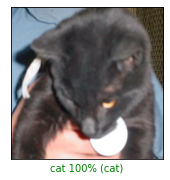

In [79]:
#@title Visualize the outputs { run: "auto" }
index = 5 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()